In [36]:
import sparrowpy as sp
import pyfar as pf
import numpy as np
import matplotlib.pyplot as plt
import os
import trimesh as tm

%matplotlib inline
font={
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": "Helvetica",
    "font.size": 11,
}
plt.rcParams.update(font)

base_dir = os.getcwd()

In [37]:
import json
def loadSceneProperties(scene_name = "seminar"):

    with open(os.path.join(base_dir,"resources",scene_name+"_scene.json")) as json_file:
        data = json.load(json_file)

    return data

In [38]:
props = loadSceneProperties("seminar")

# simulation settings
etc_time_resolution = props["etc_step"]

materials = np.array(list(props["materials"].keys()))

speed_of_sound = props["sound_speed"]

att_dB = np.array(props["air_att"])


In [39]:
#radiosity object from file, whole wall-patch shabang
radi = sp.DirectionalRadiosityFast.from_file(
                filepath="resources/seminar.blend",
                wall_auto_assembly=False,
                geometry_identifier="Geometry",
                patch_identifier="PointCloud",
                )

C:\Users\WS2080-01\AppData\Local\Temp\ipykernel_35644\3493331638.py:2: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.equal_angle.'
  samples = pf.samplings.sph_equal_angle(delta_angles=20)


<Axes3D: xlabel='x in m', ylabel='y in m', zlabel='z in m'>

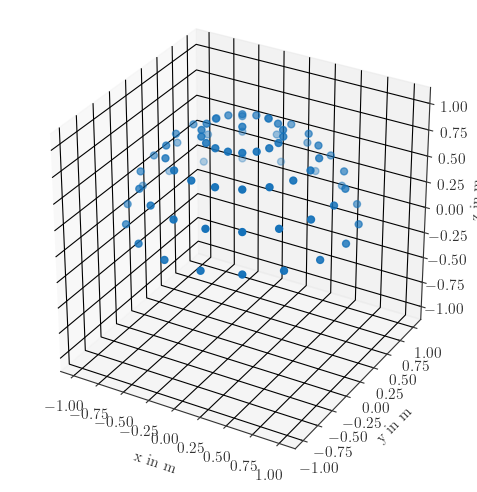

In [40]:
# set brdfs
samples = pf.samplings.sph_equal_angle(delta_angles=20)
samples.weights=np.ones(samples.cshape[0])

brdf_sources = samples[np.where((samples.elevation*180/np.pi >= 0))].copy()
brdf_receivers = samples[np.where((samples.elevation*180/np.pi >= 0))].copy()

brdf_sources.show()


In [ ]:
# set brdfs
frequencies = np.array([props["f"]]).flatten()

# set air absorption
att_Np = att_dB*.115129254

radi.set_air_attenuation(
    pf.FrequencyData(
        att_Np*np.ones_like(frequencies),
        frequencies))

for i,material in enumerate(materials):

    brdf = sp.brdf.create_from_scattering(
        brdf_sources,
        brdf_receivers,
        pf.FrequencyData(np.array(props["materials"][material]["scattering"]),
                         frequencies),
        pf.FrequencyData(np.array(props["materials"][material]["absorption"]),
                         frequencies))

    # set directional scattering data
    radi.set_wall_brdf(
        np.where(radi._walls_material==material)[0],
        brdf,
        brdf_sources,
        brdf_receivers)

print(radi.n_patches)

In [42]:
# bake geometry and save
radi.bake_geometry()
#radi.write(os.path.join(base_dir,"seminar.far"),compress=False)

AttributeError: 'NoneType' object has no attribute 'cartesian'

In [ ]:
# read
radi=sp.DirectionalRadiosityFast.from_read(os.path.join(base_dir,"seminar.far"))

source = pf.Coordinates(props["source"]["position"][0],
                        props["source"]["position"][1],
                        props["source"]["position"][2])

# initialize source energy
radi.init_source_energy(source)

radi.write(os.path.join(base_dir,"seminar_se.far"),compress=False)

FileNotFoundError: [Errno 2] No such file or directory: 'd:\\Joao_Fatela\\dev\\sparrowpy\\examples\\seminar.far'

In [ ]:
radi=sp.DirectionalRadiosityFast.from_read(os.path.join(base_dir,"seminar_se.far"))

radi.calculate_energy_exchange(
        speed_of_sound=speed_of_sound,
        etc_time_resolution=etc_time_resolution,
        etc_duration=props["etc_duration"],
        max_reflection_order=50,
        recalculate=True)

radi.write(os.path.join(base_dir,"seminar_ee.far"),compress=False)

In [ ]:
receiver = pf.Coordinates(props["receiver"]["position"][0],
                          props["receiver"]["position"][1],
                          props["receiver"]["position"][2])

etc_radiosity = radi.collect_energy_receiver_mono(
    receivers=receiver)


In [ ]:
%load_ext watermark
%watermark -v -m -iv

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.31.0

Compiler    : MSC v.1938 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 13, GenuineIntel
CPU cores   : 8
Architecture: 64bit

pyfar     : 0.7.1
matplotlib: 3.10.0
sparrowpy : 0.1.0
numpy     : 1.26.4

